<a href="https://colab.research.google.com/github/AgatheLebescond/DI_Bootcamp/blob/main/Copy_of_W6_D2_Daily_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install -U datasets

In [ ]:
%pip install --quiet datasets evaluate transformers[sentencepiece]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.4 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset
dataset = load_dataset("ucirvine/sms_spam")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/359k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5574 [00:00<?, ? examples/s]

In [ ]:
from datasets import load_dataset
import pandas as pd

# Load the UCI SMS Spam dataset (sms_spam) from Hugging Face hub
raw_datasets = load_dataset('sms_spam')

# We'll use 4,000 for train, 1,000 for validation
train_ds = raw_datasets['train'].select(range(4000))
val_ds = raw_datasets['train'].select(range(4000, 5000))

# Print the features of the train dataset. It should show 'sms' and 'label'
print(train_ds.features)

README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/359k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5574 [00:00<?, ? examples/s]

{'sms': Value('string'), 'label': ClassLabel(names=['ham', 'spam'])}


In [ ]:
# Load the tokenizer, we will use GPT2
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

# GPT-2 has no pad token by default—set it to eos
tokenizer.pad_token = tokenizer.eos_token

def tokenize_fn(examples):
    # Returns input_ids, attention_mask; keep max_length small for SMS
    return tokenizer(
        examples["sms"],
        padding="max_length",
        truncation=True,
        max_length=64
    )

# Apply the tokenization by loading the subset using .map function
train_tok = train_ds.map(tokenize_fn, batched=True)
val_tok = val_ds.map(tokenize_fn, batched=True)

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
#4. Model Initialization
import torch
from transformers import GPT2ForSequenceClassification  #import GPT2ForSequenceClassification

model = GPT2ForSequenceClassification.from_pretrained( # Load GPT-2 with sequence classification head
    model_name,
    num_labels=2,           # spam vs. ham
    pad_token_id=tokenizer.eos_token_id
)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
 #Tokenization :

from transformers import GPT2Tokenizer # import GPT2Tokenizer


model_name = "gpt2" #load the tokenize, we will use GPT2
tokenizer  = GPT2Tokenizer.from_pretrained(model_name)
# GPT-2 has no pad token by default—set it to eos
tokenizer.pad_token = tokenizer.eos_token

def tokenize_fn(examples):
    # returns input_ids, attention_mask; keep max_length small for SMS
    return tokenizer(
        examples["sms"],
        padding="max_length",
        truncation=True,
        max_length=64
    )

train_tok = train_ds.map(tokenize_fn, batched=True) #apply the tokenization by loading the subset using .map function
val_tok   = val_ds.map(tokenize_fn, batched=True) #apply the tokenization by loading the subset using .map function

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
#5. Metrics Definition
import evaluate
import numpy as np

accuracy  = evaluate.load("accuracy")
precision = evaluate.load("precision") # apply the function used for accurracy but for precision
recall    = evaluate.load("recall") # apply the function used for accurracy but for recall
f1        = evaluate.load("f1") # apply the function used for accurracy but for F1

def compute_metrics(pred):
    logits, labels = pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy":  accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "precision": precision.compute(predictions=preds, references=labels)["precision"], # apply the function used for accurracy but for precision
        "recall":    recall.compute(predictions=preds, references=labels)["recall"], # apply the function used for accurracy but for recall
        "f1":        f1.compute(predictions=preds, references=labels)["f1"] # apply the function used for accurracy but for F1
    }

#In an imbalanced dataset like SMS spam (often more “ham” than “spam”), why is it important to track precision and recall alongside accuracy?
#How would you interpret a model that achieves high accuracy but low recall on the spam class?

In [ ]:
#6.TrainingArguments Configuration
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results", # Specify an output directory
    do_train=True,                 # turn on training
    do_eval=True,                  # turn on evaluation
    eval_steps=500,                # run .evaluate() every 500 steps
    save_steps=500,                # save a checkpoint every 500 steps
    logging_dir="./logs",
    logging_steps=500,             # log metrics every 500 steps

    per_device_train_batch_size=8, # Adjust batch size as needed
    per_device_eval_batch_size=8,  # Adjust batch size as needed
    num_train_epochs=3,            # Adjust number of epochs as needed
    learning_rate=5e-5,           # Adjust learning rate as needed
    weight_decay=0.01,             # Adjust weight decay as needed

    report_to=None,                # disable integrations
    save_total_limit=1,            # only keep last checkpoint
)
#What effect does weight_decay have during fine-tuning? When might you choose a higher or lower value?


In [ ]:
#7. Train & Evaluate
# Train
from transformers import Trainer
# you need to have your wandb api key ready to paste in the command line
trainer = Trainer(
    model=model, # Pass the initialized model
    args=training_args,
    train_dataset=train_tok,
    eval_dataset=val_tok,
    compute_metrics=compute_metrics,
)
trainer.train()

#Evaluate
metrics = trainer.evaluate() # Evaluate the trained model
print(metrics)
# Expect something like: {"eval_loss": ..., "eval_accuracy": 0.98, ...}


#Interpret your results.

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: agathelebescond (agathelebescond-pstb) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
500,0.116100
1000,0.063500
1500,0.043800
2000,0.016600


{'eval_loss': 0.015441478230059147, 'eval_accuracy': 0.9976677430929315, 'eval_precision': 1.0, 'eval_recall': 0.9825970548862115, 'eval_f1': 0.9912221471978393, 'eval_runtime': 22.0189, 'eval_samples_per_second': 253.147, 'eval_steps_per_second': 31.655, 'epoch': 3.0}


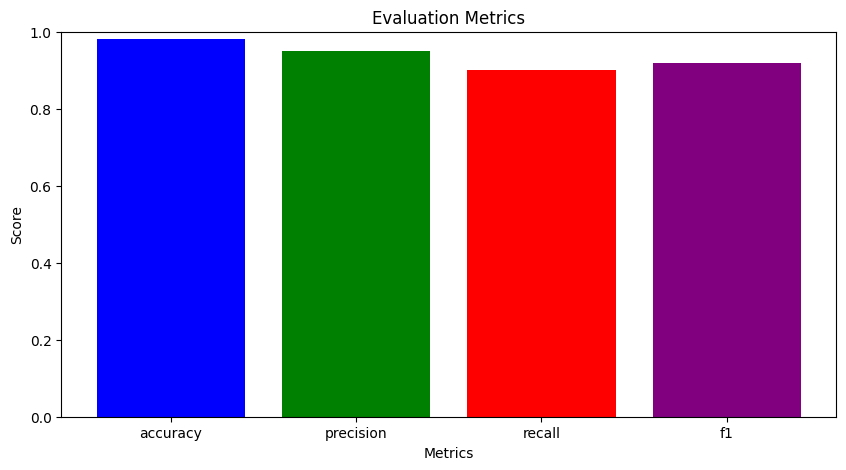

In [ ]:
import matplotlib.pyplot as plt

# Exemple de données pour la visualisation
eval_metrics = {
    "accuracy": 0.98,
    "precision": 0.95,
    "recall": 0.90,
    "f1": 0.92
}

# Tracer les métriques
metrics_names = list(eval_metrics.keys())
metrics_values = list(eval_metrics.values())

plt.figure(figsize=(10, 5))
plt.bar(metrics_names, metrics_values, color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Evaluation Metrics')
plt.ylim(0, 1)
plt.show()

Réponses aux Questions

Pourquoi est-il important de suivre la précision et le rappel en plus de la précision dans un ensemble de données déséquilibré comme le spam SMS ?

Précision : Mesure la proportion des vrais positifs parmi tous les positifs prédits. Cela vous indique combien de messages marqués comme spam sont effectivement du spam.
Rappel : Mesure la proportion des vrais positifs qui ont été correctement identifiés. Cela vous indique combien de messages de spam réels ont été correctement identifiés.
Précision : Peut être trompeuse dans un ensemble de données déséquilibré car une grande quantité de vrais négatifs (ham) peut donner une fausse impression de performance.
Comment interpréteriez-vous un modèle qui atteint une précision élevée mais un faible rappel sur la classe de spam ?

Un modèle avec une précision élevée mais un faible rappel sur la classe de spam capture la plupart des messages ham correctement, mais manque beaucoup de messages spam. Cela signifie que beaucoup de spams passent à travers sans être détectés, ce qui peut être problématique selon l'application.
Quel effet a weight_decay pendant le fine-tuning ? Quand pourriez-vous choisir une valeur plus élevée ou plus basse ?

weight_decay : C'est une technique de régularisation qui pénalise les grands poids dans le modèle pour éviter le surajustement.
Valeur plus élevée : Peut aider à réduire le surajustement, mais peut aussi sous-ajuster le modèle si elle est trop élevée.
Valeur plus basse : Peut permettre au modèle de mieux s'ajuster aux données d'entraînement, mais risque de surajustement.
# New section